In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import sys
sys.path.append("../src")

from dnadb import dna, fastq
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from scipy.spatial.distance import cdist
import wandb

from deepdna import metrics
from deepdna.data.dataset import Dataset
from deepdna.nn.data_generators import SequenceSampler
from deepdna.nn.models import load_model, dnabert, setbert
from deepdna.nn import layers

In [2]:
SEED = 0

In [3]:
api = wandb.Api()

## Models

In [4]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
dnabert_encoder = dnabert.DnaBertEncoderModel(
    load_model(path, dnabert.DnaBertPretrainModel).base,
    subsamples=True
)

wandb:   4 of 4 files downloaded.  


In [5]:
path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-nachusa-64:latest").download()
base = load_model(path, setbert.SetBertModel)

wandb:   4 of 4 files downloaded.  


In [6]:
setbert_encoder = setbert.SetBertEncoderModel(base)

---

## Data

Datasets to choose samples from.

In [7]:
dataset_names = [
    "Nachusa-2015",
    "Nachusa-2016",
    "Nachusa-2017",
    "Nachusa-2020"
]

Create dataset instances.

In [8]:
datasets = [Dataset(f"/home/dwl2x/Datasets/{name}/0") for name in dataset_names]

Find all FASTQ DB sample files to choose from across all of the datasets and shuffle them.

In [12]:
sample_paths = [path for dataset in datasets for path in dataset.fastq_dbs(Dataset.Split.Test)]
np.random.default_rng(SEED).shuffle(sample_paths) # type: ignore
len(sample_paths)

210

Pick some samples.

In [13]:
chosen_sample_paths = sample_paths[:10]
chosen_sample_paths

[PosixPath('/home/dwl2x/Datasets/Nachusa-2015/0/test/WS-CCW-Jul2015_S82_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2017/0/test/Wes52-10-TC_S53_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2016/0/test/WS-TCR-Oct2016_S80_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2017/0/test/Wes41-10-HN_S42_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2020/0/test/Wesley026-Ag-072820_S165_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2016/0/test/WS-FC-Jul2016_S94_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2017/0/test/Wes5-5-CCE_S6_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2016/0/test/WS-CCE-Jul2016_S47_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2016/0/test/WS-HLP-Apr2016_S77_L001_R1_001.fastq.db'),
 PosixPath('/home/dwl2x/Datasets/Nachusa-2020/0/test/Wesley012-HN-051120_S151_L001_R1_001.fastq.db')]

Open the samples

In [14]:
samples = [fastq.FastqDb(path) for path in chosen_sample_paths]
sample_names = [sample.path.name.rstrip(".fastq.db") for sample in samples]
sample_names

['WS-CCW-Jul2015_S82_L001_R1_001',
 'Wes52-10-TC_S53_L001_R1_001',
 'WS-TCR-Oct2016_S80_L001_R1_001',
 'Wes41-10-HN_S42_L001_R1_001',
 'Wesley026-Ag-072820_S165_L001_R1_001',
 'WS-FC-Jul2016_S94_L001_R1_001',
 'Wes5-5-CCE_S6_L001_R1_001',
 'WS-CCE-Jul2016_S47_L001_R1_001',
 'WS-HLP-Apr2016_S77_L001_R1_001',
 'Wesley012-HN-051120_S151_L001_R1_001']

Draw random subsamples using the SequenceSampler.

In [15]:
rng = np.random.default_rng(SEED + 1)
subsamples_list = []
for sample in samples:
    sampler = SequenceSampler([sample], 150)
    sequences = sampler.sequences(sampler.random_entries(10, 1000, rng)[1], rng)
    sequences = dna.encode_kmers(sequences, dnabert_encoder.base.kmer) # type: ignore
    sequences = dnabert_encoder.predict(sequences, batch_size=1)
    subsamples_list.append(sequences)
subsamples = np.array(subsamples_list)
subsamples.shape

10/10 [==============================] - 3s 284ms/step


(10, 10, 1000, 64)

Encoder the subsamples using SetBERT

In [16]:
shape = subsamples.shape
encoded_subsamples = setbert_encoder.predict(
    tf.reshape(subsamples, (-1, *shape[2:])), batch_size=1).reshape((*shape[:2], shape[-1]))

100/100 [==============================] - 1s 5ms/step


## MDS Projections

In [17]:
distance_measure = "cityblock"
metric = True

In [18]:
flat: np.ndarray = encoded_subsamples.reshape((-1, encoded_subsamples.shape[-1]))
distance_matrix = cdist(flat, flat, distance_measure)
distance_matrix.shape

(100, 100)

In [19]:
mds, _ = metrics.mds(distance_matrix, ndim=2, metric=metric, seed=SEED)
mds = mds.reshape(len(samples), -1, 2)
mds.shape

(10, 10, 2)

In [20]:
def mds_stress_analysis(dist_mat, dims, metric=True, seed=None, workers=1, **kwargs):
    """
    Compute the MDS stress value for the given possible range of components.
    """
    import multiprocessing
    if isinstance(dims, int):
        dims = range(1, dims+1)
    dims = list(dims)
    with multiprocessing.Pool(workers) as pool:
        stresses = pool.map(metrics.MdsStressAnalysisProcess(
            dist_mat, metric=metric, random_state=seed, **kwargs
        ), dims)
    print(stresses)
    return dims, stresses #(1 - np.cumsum(stresses) / np.sum(stresses))

In [21]:
mds_stress = metrics.mds_stress_analysis(distance_matrix, 64, metric=metric, seed=SEED, workers=1)

/tmp/ipykernel_509133/3517188825.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


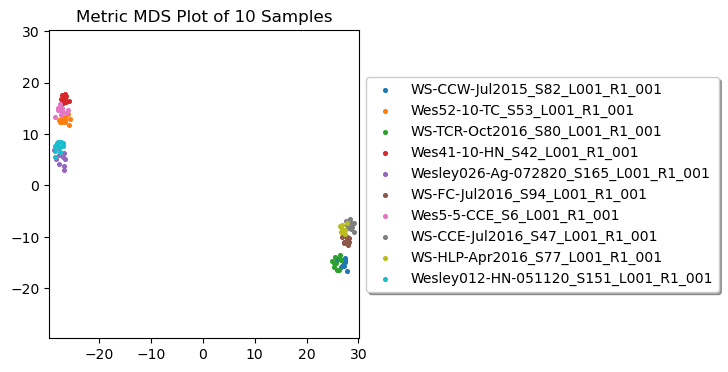

In [28]:
plt.figure(figsize=(4, 4))
# plt.subplot(1, 2, 1)
plt.title(f"Metric MDS Plot of {len(samples)} Samples")
for sample, points in zip(sample_names, mds):
    plt.scatter(points[:,0], points[:,1], label=sample, s=7)
plt.xlim((np.min(mds) - 1, np.max(mds) + 1))
plt.ylim((np.min(mds) - 1, np.max(mds) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)

# plt.subplot(1, 2, 2)
# plt.title("MDS Stress Scree Plot")
# plt.plot(*mds_stress)
# plt.xlabel("Number of Components")
# plt.ylabel("1 - Cumulative Stress")
# plt.tight_layout()
# plt.savefig("mds_scree_plot.png")
plt.tight_layout()
plt.show()

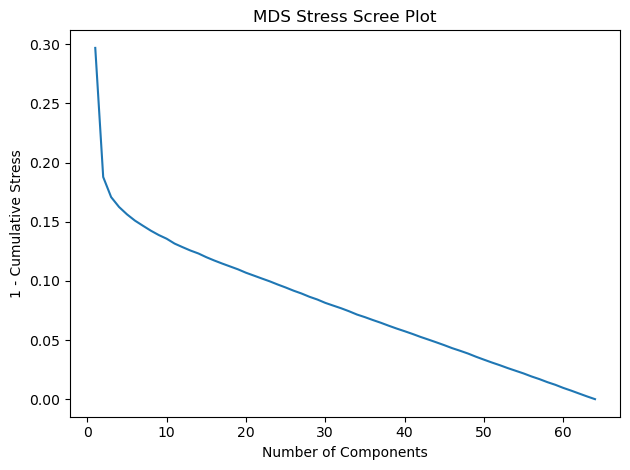

In [29]:
plt.title("MDS Stress Scree Plot")
plt.plot(*mds_stress)
plt.xlabel("Number of Components")
plt.ylabel("1 - Cumulative Stress")
plt.tight_layout()
plt.show()

In [23]:
encoded_subsamples.shape

(10, 10, 64)

In [24]:
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(encoded_subsamples.reshape((-1, encoded_subsamples.shape[-1])))
labels

array([4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 7, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [25]:
labels.reshape(10, 10)

array([[4, 4, 3, 4, 4, 4, 4, 4, 4, 4],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 7, 2, 2],
       [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]], dtype=int32)

In [26]:
unique_labels = np.unique(labels)
unique_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [27]:
normalized_mutual_info_score(np.repeat(np.arange(len(encoded_subsamples)), 10), labels)

0.9713161523998449